In [66]:
# import sys
# !{sys.executable} -m pip install --user plotly.express
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import numpy as np
import plotly.express as px

In [67]:
# Load the CSV data
df = pd.read_csv('cleaned_heart_disease_kmodes.csv')
# df = pd.read_csv('cleaned_heart_disease_majority.csv')
# df = pd.read_csv('heart_disease_remove_empty.csv')
numerical_vars = [
    "Age", "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours", 
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

categorical_vars = [
    'Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 
    'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sugar Consumption'
    ]

In [ ]:
def Age_with_X(X):
    '''
    explore factor X with Heart disease rate among different age
    '''
    # Mapping Heart Disease Status from categorical ('Yes'/'No') to binary (1/0)
    if df['Heart Disease Status'].dtype == 'O': 
        mapping = {'Yes': 1, 'No': 0}
        df['Heart Disease Status'] = df['Heart Disease Status'].map(mapping)

    # Create age groups 
    bins = [0, 30, 40, 50, 60, 70, 80, 100]
    labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

    # Group by AgeGroup and Smoking to calculate the average (proportion) of heart disease.
    # Since Heart Disease Status is 0/1, the mean gives the proportion of cases.
    result = df.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
    # print("Heart Disease Proportion by Age Group and %s Status:" % X)
    # print(result)

    # Visualize the proportions with a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=result, x='AgeGroup', y='Heart Disease Status', hue= X)
    plt.ylabel('Proportion with Heart Disease')
    plt.title('Heart Disease Proportion by %s Status and Age Group' % X)

    # Save the figure before showing it
    filename = f'heart_disease_proportion_by_{X}.png'  # Saves dynamically based on X
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save at high quality

    # plt.show()


In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

for cate in categorical_columns[:len(categorical_columns)-1]:
    Age_with_X(cate)


In [ ]:
# perform a chi-squared test for each age group to test the association
def chi2_test_age_group(group,X):
    # Create a contingency table for Smoking vs. Heart Disease Status
    contingency_table = pd.crosstab(group[X], group['Heart Disease Status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return pd.Series({'Chi2': chi2, 'p-value': p, 'Degrees of Freedom': dof})


In [ ]:
'''
chi2 for age
'''

chi2_results = df.groupby('AgeGroup').apply(lambda g:chi2_test_age_group(g,'Smoking')).reset_index()
print("\nChi-squared Test Results by Age Group:")
print(chi2_results)


In [ ]:
'''exercise habit and age'''

anova_p = f_oneway(
    df[df["Exercise Habits"] == "Low"]["Age"],
    df[df["Exercise Habits"] == "Medium"]["Age"],
    df[df["Exercise Habits"] == "High"]["Age"]
)

print("\nANOVA: Age vs. Exercise Habits")
print(f"F-statistic: {anova_p.statistic:.2f}, p-value: {anova_p.pvalue:.4f}")
if anova_p.pvalue < 0.05:
    print("=> Significant difference in Exercise Habits among different Age.")
else:
    print("=> No significant difference in Exercise Habits among Age.")

# Define the age bins and labels for grouping
bins = [0, 30, 40, 50, 60, 70, 80, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

exercise_counts = df.groupby(["AgeGroup", "Exercise Habits"]).size().reset_index(name="Count")
total_counts = df.groupby("AgeGroup")["Exercise Habits"].count().reset_index(name="Total")

# Merge and compute proportions
exercise_counts = exercise_counts.merge(total_counts, on="AgeGroup")
exercise_counts["Proportion"] = exercise_counts["Count"] / exercise_counts["Total"]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=exercise_counts, x="AgeGroup", y="Proportion", hue="Exercise Habits", palette="coolwarm")
plt.title("Proportion of Exercise Habits by AgeGroup")
plt.ylabel("Proportion")
plt.xlabel("AgeGroup")
plt.legend(title="Exercise Habits")
plt.ylim(0, 1)  # Ensures values range between 0 and 1
plt.show()

In [ ]:
'''Stress Level vs. sleep hour vs. heart disease'''

if df['Heart Disease Status'].dtype == 'O':
    df['Heart Disease Status'] = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

# -------------------------------
# Step 1: Chi-Square Test - Stress Level & Heart Disease
# -------------------------------
contingency_table = pd.crosstab(df["Stress Level"], df["Heart Disease Status"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Test: Stress Level vs. Heart Disease Status")
print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("=> There is a significant relationship between Stress Level and Heart Disease.")
else:
    print("=> No significant relationship between Stress Level and Heart Disease.")

# -------------------------------
# Step 2: T-test / ANOVA - Sleep Hours Across Heart Disease Status
# -------------------------------
group_no_hd = df[df["Heart Disease Status"] == 0]["Sleep Hours"]
group_yes_hd = df[df["Heart Disease Status"] == 1]["Sleep Hours"]

t_stat, p_val = ttest_ind(group_no_hd, group_yes_hd, equal_var=False)
print("\nT-Test: Sleep Hours vs. Heart Disease Status")
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("=> Sleep Hours significantly differs between those with and without Heart Disease.")
else:
    print("=> No significant difference in Sleep Hours between groups.")

# -------------------------------
# Step 3: ANOVA - Sleep Hours Across Stress Levels
# -------------------------------
anova_p = f_oneway(
    df[df["Stress Level"] == "Low"]["Sleep Hours"],
    df[df["Stress Level"] == "Medium"]["Sleep Hours"],
    df[df["Stress Level"] == "High"]["Sleep Hours"]
)

print("\nANOVA: Sleep Hours vs. Stress Level")
print(f"F-statistic: {anova_p.statistic:.2f}, p-value: {anova_p.pvalue:.4f}")
if anova_p.pvalue < 0.05:
    print("=> Significant difference in Sleep Hours among different Stress Levels.")
else:
    print("=> No significant difference in Sleep Hours among Stress Levels.")

# Compute the proportion of people with heart disease in each stress level category
stress_hd = df.groupby("Stress Level")["Heart Disease Status"].mean().reset_index()

# Plot a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=stress_hd, x="Stress Level", y="Heart Disease Status", palette="coolwarm")

plt.ylabel("Proportion with Heart Disease")
plt.title("Heart Disease Rate by Stress Level")
plt.ylim(0, 1)  # Since it's a proportion (0 to 1)
plt.show()


In [ ]:
'''what factor affect gender vs heart disease'''
# Filter for patients with heart disease
df_hd = df[df["Heart Disease Status"] == 'Yes']

# Separate the heart disease patients by Gender
df_hd_f = df_hd[df_hd["Gender"] == "Female"]
df_hd_m = df_hd[df_hd["Gender"] == "Male"]



print("Continuous Variables Comparison between Female and Male Heart Disease Patients:")
results_continuous = []
for var in numerical_vars:
    
    # Perform an independent t-test
    t_stat, p_val = ttest_ind(df_hd_f[var], df_hd_m[var], equal_var=False)
    
    results_continuous.append({
        "Variable": var, 
        "t-statistic": t_stat, "p-value": p_val
    })

results_cont_df = pd.DataFrame(results_continuous)
print(results_cont_df)
for index, row in results_cont_df.iterrows():
    if row["p-value"] < 0.05:
        print(f"{row['Variable']} is a significant factor affecting heart disease rate among gender (p-value = {row['p-value']:.4f}).")

# -----------------------------------
# Categorical Variables Comparison
# -----------------------------------

if 'Gender' in categorical_vars:
    categorical_vars_gen = [x for x in categorical_vars if x != 'Gender']
print("\nCategorical Variables Comparison between Female and Male Heart Disease Patients:")
results_categorical = []
for var in categorical_vars_gen:
    # Build a contingency table for the variable and Gender
    contingency_table = pd.crosstab(df_hd[var], df_hd["Gender"])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    
    results_categorical.append({
        "Variable": var,
        "Chi2": chi2, "p-value": p_val
    })

results_cat_df = pd.DataFrame(results_categorical)
for index, row in results_cat_df.iterrows():
    if row["p-value"] < 0.05:
        print(f"{row['Variable']} is a significant factor affecting heart disease rate among gender (p-value = {row['p-value']:.4f}).")
# print(results_cat_df)

# Transform p-values to -log10(p_value) for easier visualization of significance.
results_cat_df["neg_log10_p"] = -np.log10(results_cat_df["p-value"])

# Sort the results for a clearer view (optional)
results_cat_df = results_cat_df.sort_values("neg_log10_p", ascending=False)

# Create a color list to highlight Alcohol Consumption in red
colors = ['red' if var == "Alcohol Consumption" else 'grey' for var in results_cat_df["Variable"]]

plt.figure(figsize=(10, 6))
sns.barplot(x="neg_log10_p", y="Variable", data=results_cat_df, palette=colors)
plt.xlabel("-log10(p-value)")
plt.title("Significance of Categorical Factors on Heart Disease Status")

# Plot a vertical line representing the significance threshold (p = 0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, linestyle="--", color="blue", label="p = 0.05 threshold")
plt.legend()
plt.show()

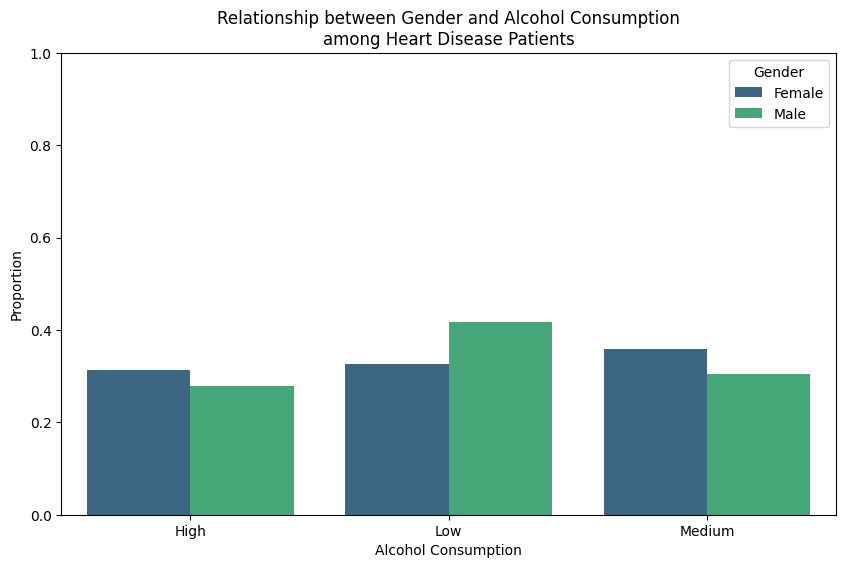

In [84]:
# Create a contingency table: rows = Alcohol Consumption, columns = Gender
ct = pd.crosstab(df_hd["Alcohol Consumption"], df_hd["Gender"])

# Normalize by columns so that for each gender, the sum of proportions equals 1
ct_norm = ct.div(ct.sum(axis=0), axis=1)

# Convert the table into a long format for plotting
ct_norm = ct_norm.reset_index().melt(id_vars="Alcohol Consumption", var_name="Gender", value_name="Proportion")

# Plot a grouped bar chart of normalized proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=ct_norm, x="Alcohol Consumption", y="Proportion", hue="Gender", palette="viridis")
plt.title("Relationship between Gender and Alcohol Consumption\namong Heart Disease Patients")
plt.xlabel("Alcohol Consumption")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.show()

C:\Users\zqy15\AppData\Local\Temp\ipykernel_27344\642690651.py:51: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




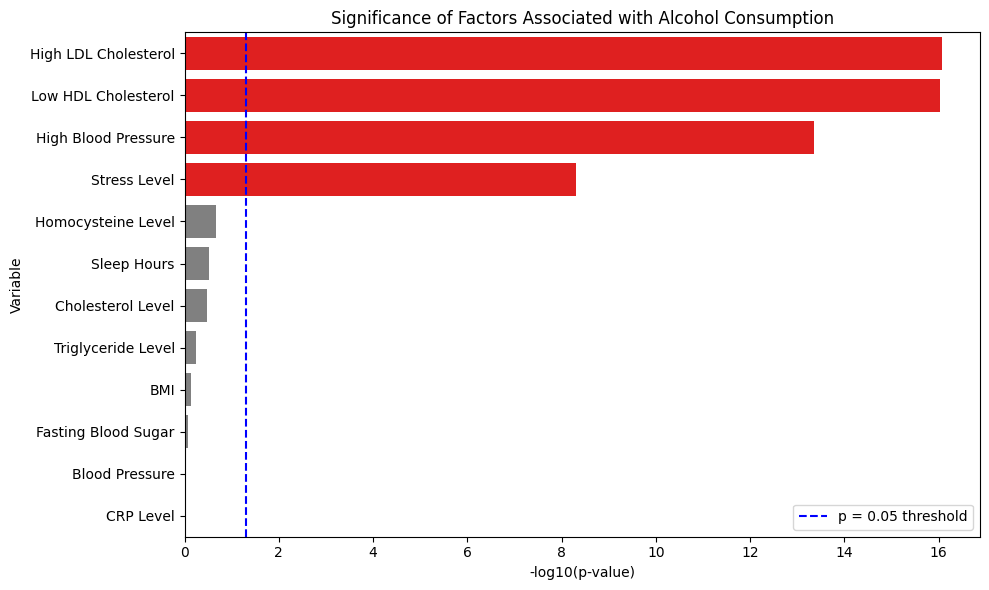

In [69]:
'''alcohol consumption can affect what'''

numerical_vars = [
    "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours", 
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

categorical_vars_al = ['High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level']
results_cont = []
# Evaluate continuous variables using one-way ANOVA across different alcohol consumption groups
for var in numerical_vars:
    # Get the groups by alcohol consumption level
    groups = [group[var] for name, group in df.groupby('Alcohol Consumption')]
    if len(groups) > 1:  # Only if there are at least 2 groups
        f_stat, p_val = f_oneway(*groups)
        results_cont.append({
            "Variable": var,
            "Test": "ANOVA",
            "Statistic": f_stat,
            "p-value": p_val
        })

results_cat = []
# Evaluate categorical variables using a chi-square test
for var in categorical_vars_al:
    contingency = pd.crosstab(df[var], df['Alcohol Consumption'])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    results_cat.append({
        "Variable": var,
        "Test": "Chi-square",
        "Statistic": chi2,
        "p-value": p_val
    })

# Combine the results into one DataFrame
results_df = pd.DataFrame(results_cont + results_cat)

# Calculate -log10(p-value) for easier visualization (larger values = more significant)
results_df["neg_log10_p"] = -np.log10(results_df["p-value"])

# Flag significant factors (p < 0.05)
results_df["Significant"] = results_df["p-value"] < 0.05

# Sort results for plotting (most significant at the top)
results_df = results_df.sort_values("neg_log10_p", ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
# Color bars red if significant, grey otherwise
colors = ["red" if sig else "grey" for sig in results_df["Significant"]]
sns.barplot(x="neg_log10_p", y="Variable", data=results_df, palette=colors)
plt.xlabel("-log10(p-value)")
plt.title("Significance of Factors Associated with Alcohol Consumption")

# Draw the significance threshold line (p=0.05 corresponds to -log10(0.05))
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, linestyle="--", color="blue", label="p = 0.05 threshold")
plt.legend()
plt.tight_layout()
plt.show()

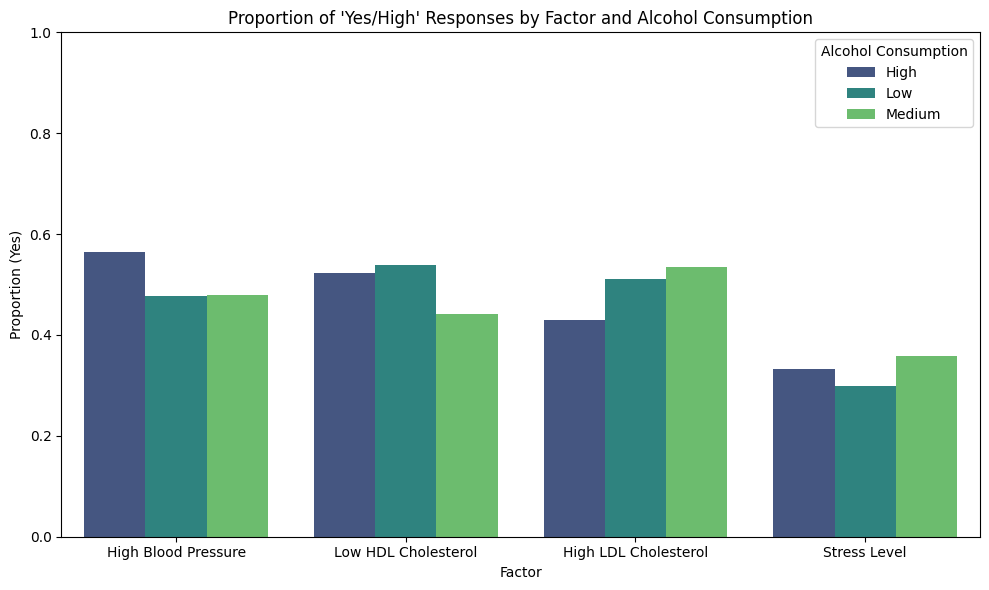

In [81]:
# List of factors to examine
factors = ['High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level']

# Create an empty list to hold aggregated normalized data
agg_data = []

# Get the sorted unique categories for Alcohol Consumption
alc_categories = sorted(df["Alcohol Consumption"].unique())

for factor in factors:
    for alc in alc_categories:
        subset = df[df["Alcohol Consumption"] == alc]
        # Use "High" for Stress Level, "Yes" for others
        pos_val = "High" if factor == "Stress Level" else "Yes"
        proportion = (subset[factor] == pos_val).mean()
        agg_data.append({
            "Factor": factor,
            "Alcohol Consumption": alc,
            "Proportion": proportion
        })

# Create a DataFrame from the aggregated data
agg_df = pd.DataFrame(agg_data)

# Plot a grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df, x="Factor", y="Proportion", hue="Alcohol Consumption", palette="viridis")
plt.title("Proportion of 'Yes/High' Responses by Factor and Alcohol Consumption")
plt.xlabel("Factor")
plt.ylabel("Proportion (Yes)")
plt.ylim(0, 1)
plt.legend(title="Alcohol Consumption", loc="upper right")
plt.tight_layout()
plt.show()